In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import CSVLogger
from tensorflow.python.keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten

from keras.layers import Flatten, Dropout,GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences





/Users/polinab/.virtualenvs/deep/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/polinab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import and explore data

In [2]:
yelp_labelled = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
yelp_labelled.columns = ['text', 'label']
yelp_labelled.head(5)

,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


<AxesSubplot:xlabel='label', ylabel='Count'>

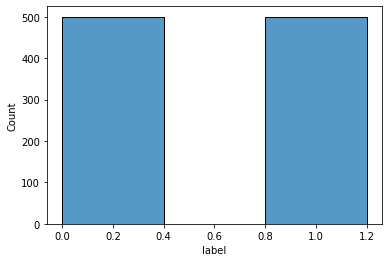

In [3]:
sns.histplot(data=yelp_labelled, x="label",bins=2,binwidth=0.4)


- 0 and 1 labels are equally distributed, so we do not need to resample the data
- 0 is a bad review, 1 is a good review
- small set of data, so we can use all of it

,text,label
195,The best place to go for a tasty bowl of Pho!,1
452,I am far from a sushi connoisseur but I can de...,0
866,This place is awesome if you want something li...,1
862,"Hot dishes are not hot, cold dishes are close ...",0
621,Very disappointing!!!,0


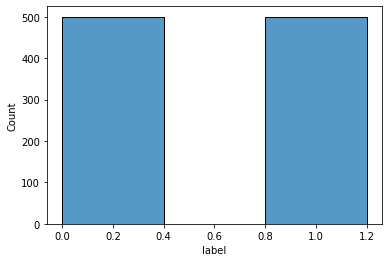

In [4]:
y = yelp_labelled['label']
train_df, test_df = train_test_split(yelp_labelled, test_size=0.2)
sns.histplot(data=yelp_labelled, x="label",bins=2,binwidth=0.4)
train_df.head()


### Vectorize the word data: building my own word dictionary
- a neural network model cannot interpret words, they need to be encoded into numbers
- external libraries exist that do this, like Word2Vec
- After playing around with the libraries I decided to make my own encoding to fully understand how the basics work
- getting rid of stop words made the model perform worse. Understandable since sequentially many of the stop words actually add information to the phrases! 

In [5]:
# separate into positive and negative posts
positive_posts = pd.Series.to_numpy(yelp_labelled[yelp_labelled.label == 1]['text'])
negative_posts = pd.Series.to_numpy(yelp_labelled[yelp_labelled.label == 0]['text'])

# keep an object with both sets for later use
posts = np.append(negative_posts, positive_posts, axis=0)

longest_post = max(len(post) for post in posts)
longest_post


149

In [6]:
def unique_words(lines):
    '''
    returns dictionary of unique words in input
    assigns an integer key to each word
    does not include punctuation or stop words 
    stop words can be removed or included depending on the model
    '''
    unique_words = set()
    stop_words = set(stopwords.words('english'))

    for line in lines:
        for word in line:
#             if word not in stop_words:
#                 unique_words.add(word)
            unique_words.add(word)
    word_vals = set(i for i in range(len(unique_words)))
    word_keys = dict(zip(unique_words, word_vals))
    return word_keys

def word_to_vec(posts):
    '''
    encodes word input into integer arrays 
    stop words can be removed or included depending on the model
    '''
    stop_words = set(stopwords.words('english'))
    posts = [line.lower().translate(str.maketrans('', '', string.punctuation)).split(' ') for line in posts]
    word_dict = unique_words(posts)
    word_key_map = [[word_dict[word] for word in post] for post in posts]
#     word_key_map = [[word_dict[word] for word in post if word not in stop_words] for post in posts]
    return word_key_map

In [10]:
neg_encoded = word_to_vec(negative_posts)
pos_encoded = word_to_vec(positive_posts)
word_vecs = np.concatenate((neg_encoded, pos_encoded))
print(f'"{negative_posts[0]}" becomes {word_vecs[0]}')


"Crust is not good." becomes [716, 837, 1380, 491]


In [11]:
# Padding the data samples to a maximum review length in words
longest_post = max([len(post) for post in word_to_vec(posts)])
padded_word_vecs = sequence.pad_sequences(word_vecs, maxlen=longest_post)


In [12]:
# re-create labels, concatenate with data, and set up test/train split
labels = np.concatenate((np.zeros(len(neg_encoded)), np.ones(len(pos_encoded))))
X_train, X_test, y_train, y_test = train_test_split(padded_word_vecs,labels,test_size=0.33)

print('X_train shape:', X_train.shape, y_train.shape)
print('X_test shape:', X_test.shape, y_test.shape)


X_train shape: (670, 32) (670,)
X_test shape: (330, 32) (330,)


### Word-wise LSTM Model
LSTM is an artificial RNN architecture.
reference: https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e

In [13]:
vocab_size = max([max(arr) for arr in word_to_vec(posts)])
embedding_size = 32
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
lstm_model.add(LSTM(embedding_size))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))
print(lstm_model.summary())
# do grid search for hyperparams

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 32)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 74,913
Trainable params: 74,913
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

batch_size = 64
num_epochs = 20
csv_logger = CSVLogger("lstm.csv", append=False)
lstm_model.fit(X_train, y_train, 
               epochs=num_epochs, 
               verbose=1,
               callbacks=[csv_logger],
               validation_data=(X_test,y_test)
              )


Epoch 1/20
21/21 [==============================] - 3s 35ms/step - loss: 0.6894 - accuracy: 0.5893 - val_loss: 0.6690 - val_accuracy: 0.9121
Epoch 2/20
21/21 [==============================] - 0s 15ms/step - loss: 0.6349 - accuracy: 0.8826 - val_loss: 0.4613 - val_accuracy: 0.9273
Epoch 3/20
21/21 [==============================] - 0s 15ms/step - loss: 0.3884 - accuracy: 0.9052 - val_loss: 0.2916 - val_accuracy: 0.9242
Epoch 4/20
21/21 [==============================] - 0s 15ms/step - loss: 0.2479 - accuracy: 0.9432 - val_loss: 0.2026 - val_accuracy: 0.9424
Epoch 5/20
21/21 [==============================] - 0s 15ms/step - loss: 0.1737 - accuracy: 0.9703 - val_loss: 0.1411 - val_accuracy: 0.9970
Epoch 6/20
21/21 [==============================] - 0s 16ms/step - loss: 0.1020 - accuracy: 0.9891 - val_loss: 0.1048 - val_accuracy: 0.9636
Epoch 7/20
21/21 [==============================] - 0s 15ms/step - loss: 0.0785 - accuracy: 0.9871 - val_loss: 0.0744 - val_accuracy: 0.9909
Epoch 8/20
21

In [15]:
scores = lstm_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.9909090995788574


<AxesSubplot:xlabel='epoch'>

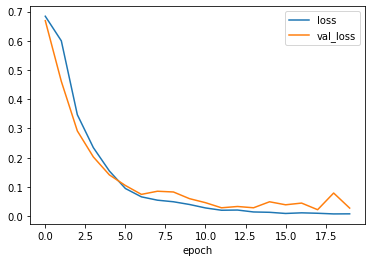

In [16]:
lstm_scores_df = pd.read_csv("lstm.csv")
lstm_scores_df.set_index('epoch', inplace=True)
# lstm_scores_df[['loss','val_loss']].plot()

lstm_scores_df[['loss','val_loss']].plot()


### Word-wise CNN Model
https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [17]:
embedding_size = 50
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
cnn_model.add(Conv1D(embedding_size,kernel_size=8, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 50)            104000    
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 50)            20050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                6010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 130,071
Trainable params: 130,071
Non-trainable params: 0
________________________________________________

In [18]:
num_epochs = 20

csv_logger = CSVLogger("cnn.csv", append=False)

cnn_model.fit(X_train, y_train, epochs=num_epochs, verbose=1)

Epoch 1/20
21/21 [==============================] - 1s 4ms/step - loss: 0.6919 - accuracy: 0.5323
Epoch 2/20
21/21 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.7467
Epoch 3/20
21/21 [==============================] - 0s 4ms/step - loss: 0.3486 - accuracy: 0.9689
Epoch 4/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0867 - accuracy: 0.9886
Epoch 5/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0393 - accuracy: 0.9895
Epoch 6/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0402 - accuracy: 0.9907
Epoch 7/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0496 - accuracy: 0.9836
Epoch 8/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0445 - accuracy: 0.9856
Epoch 9/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0095 - accuracy: 0.9969
Epoch 10/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0093 - accuracy: 0.9982
Epoch 11/20
21/21 [

In [19]:
scores = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.9878787994384766


<AxesSubplot:xlabel='epoch'>

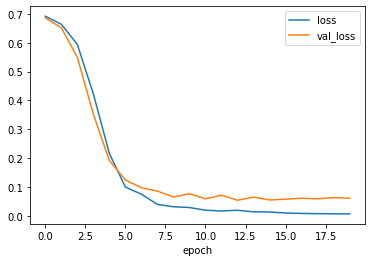

In [20]:
cnn_scores_df = pd.read_csv("cnn.csv")
cnn_scores_df.set_index('epoch', inplace=True)
cnn_scores_df[['loss','val_loss']].plot()

##### Problems with this approach:
- after coding this section, I realized that using the entire set to build the embedding dictionary is "cheating": in the real world, we would not have access to the test data
- I decided to see how much the results would be affected by separating train and test data before building the dictionary
- unfortunately, the results were much worse. This makes sense because missing words would have no assocation to a label
- this is why we want to use similarity vectors for words.
- as you can see below, the in-sample accuracy converges to nearly 1, while the validation accuracy hovers around 50%

In [36]:
def preprocess(df):
    # separate into positive and negative posts
    positive_posts = pd.Series.to_numpy(df[df.label == 1]['text'])
    negative_posts = pd.Series.to_numpy(df[df.label == 0]['text'])

    # keep an object with both sets for later use
    posts = np.append(negative_posts, positive_posts, axis=0)
    
    neg_encoded = word_to_vec(negative_posts)
    pos_encoded = word_to_vec(positive_posts)
    word_vecs = np.concatenate((neg_encoded, pos_encoded))
    
    # Padding the data samples to a maximum review length in words
#     longest_post = max([len(post) for post in word_to_vec(posts)])
    padded_word_vecs = sequence.pad_sequences(word_vecs, maxlen=149)
    
    labels = np.concatenate((np.zeros(len(neg_encoded)), np.ones(len(pos_encoded))))
    
    return padded_word_vecs,labels

X_train, y_train = preprocess(train_df)
X_test, y_test = preprocess(test_df)

print('X_train shape:', X_train.shape, y_train.shape)
print('X_test shape:', X_test.shape, y_test.shape)

vocab_size = max([max(arr) for arr in word_to_vec(posts)])
embedding_size = 32
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
lstm_model.add(LSTM(embedding_size))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))
print(lstm_model.summary())
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

batch_size = 64
num_epochs = 10
csv_logger = CSVLogger("lstm.csv", append=False)
lstm_model.fit(X_train, y_train, 
               epochs=num_epochs, 
               verbose=1,
               callbacks=[csv_logger],
               validation_data=(X_test,y_test)
              )

scores = lstm_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


X_train shape: (800, 149) (800,)
X_test shape: (200, 149) (200,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 149, 32)           77472     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 85,825
Trainable params: 85,825
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
25/25 [==============================] - 3s 50ms/step - loss: 0.6902 - accuracy: 0.5633 - val_loss: 0.6950 - val_accuracy: 0.4350
Epoch 2/10
25/25 [===================

In [21]:
#todo: play around with different values for the two models above. 
# Add different layers
# show convergence of validation loss after number of epochs
# show difference using dictionaries from full set vs just train set

### Vectorize the character data

In [22]:
def char_tokenizer(lines):
    tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
    lines_low = [[l.lower() for l in lines]]
    tk.fit_on_texts(lines_low)

    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
    char_dict = {}
    for i, char in enumerate(alphabet):
        char_dict[char] = i + 1

    # Use char_dict to replace the tk.word_index
    tk.word_index = char_dict.copy()
    # Add 'UNK' to the vocabulary
    tk.word_index[tk.oov_token] = max(char_dict.values()) + 1
    return tk

In [23]:
def embed_weights(tk):
    vocab_size = len(tk.word_index)
    embedding_weights = []
    embedding_weights.append(np.zeros(vocab_size))

    for char,i in tk.word_index.items():
        onehot = np.zeros(vocab_size)
        onehot[i-1] = 1
        embedding_weights.append(onehot)

    return np.array(embedding_weights)

In [24]:
# transform reviews into character encodings:

posts = positive_posts + negative_posts
tk = char_tokenizer(posts)
vocab_size = len(tk.word_index)
pos_seqs = tk.texts_to_sequences(positive_posts)
neg_seqs = tk.texts_to_sequences(negative_posts)
print(f'{positive_posts[0]} becomes {pos_seqs[0]}')

Wow... Loved this place. becomes [23, 15, 23, 39, 39, 39, 69, 12, 15, 22, 5, 4, 69, 20, 8, 9, 19, 69, 16, 12, 1, 3, 5, 39]


In [25]:
longest_post = max([len(x) for x in np.append(neg_seqs, pos_seqs, axis=0)])
print(f'longest post is {longest_post} characters long')

longest post is 149 characters long


/Users/polinab/.virtualenvs/deep/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [27]:
# pad data:

pos_seq_padded = pad_sequences(pos_seqs, maxlen=longest_post, padding='post')
neg_seq_padded = pad_sequences(neg_seqs, maxlen=longest_post, padding='post')

pos_data = np.array(pos_seq_padded, dtype='float32')
neg_data = np.array(neg_seq_padded, dtype='float32')
pos_data[0]

X_train shape: (670, 149) (670,)
X_test shape: (330, 149) (330,)


In [28]:
# define embedding layer 
def embed_weights(tk):
    vocab_size = len(tk.word_index)
    embedding_weights = []
    embedding_weights.append(np.zeros(vocab_size))

    for char,i in tk.word_index.items():
        onehot = np.zeros(vocab_size)
        onehot[i-1] = 1
        embedding_weights.append(onehot)

    return np.array(embedding_weights)

In [29]:
embedding_size = 69 #TODO: find where this number comes from
input_size = longest_post
em_weights = embed_weights(tk)
embedding_layer = Embedding(vocab_size+1,embedding_size,input_length=input_size,weights=[em_weights])


### Tune and run the character-wise CNN model
https://realpython.com/python-keras-text-classification/

In [30]:
cnn_char_model = Sequential()
cnn_char_model.add(embedding_layer)
cnn_char_model.add(Conv1D(embedding_size, kernel_size=8, activation='relu'))
# cnn_char_model.add(MaxPooling1D(pool_size=2))
cnn_char_model.add(GlobalMaxPooling1D())

cnn_char_model.add(Flatten())
cnn_char_model.add(Dense(10, activation='relu'))
cnn_char_model.add(Dense(1, activation='sigmoid'))
cnn_char_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn_char_model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 149, 69)           4830      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 142, 69)           38157     
_________________________________________________________________
global_max_pooling1d (Global (None, 69)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 69)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                700       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 43,698
Trainable params: 43,698
Non-trainable params: 0
__________________________________________________

In [31]:
num_epochs = 20

csv_logger = CSVLogger("cnn_char.csv", append=False)
cnn_char_model.fit(X_train, y_train, 
               epochs=num_epochs, 
               verbose=0,
               callbacks=[csv_logger],
               validation_data=(X_test,y_test)
              )

In [32]:
scores = cnn_char_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.7939394116401672


<AxesSubplot:xlabel='epoch'>

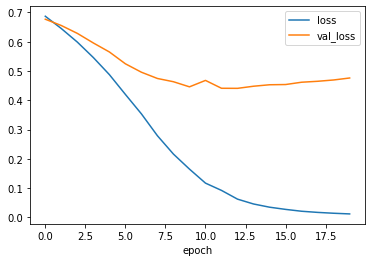

In [33]:
cnn_scores_df = pd.read_csv("cnn_char.csv")
cnn_scores_df.set_index('epoch', inplace=True)
cnn_scores_df[['loss','val_loss']].plot()
